In [1]:
from aesahaettr import calamity
from aesahaettr import covariances
from aesahaettr import visibilities
from aesahaettr import visualization
import copy
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/aaronew/science/miniconda3/envs/hera/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/home/aaronew/science/miniconda3/envs/hera/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/aaronew/science/miniconda3/envs/hera/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/aaronew/science/miniconda3/envs/hera/lib/python3.8/site-packages/hera_sim/__init__.py:23: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Ad

## Free Parameters versus baseline count.

In [2]:
nparams = []
ngains = []
ndata = []
nparams_zd = []
for nant in range(3, 12):
    evals, _ = covariances.cov_mat_simple_evecs(antenna_diameter=2.,
                                                    eigenval_cutoff=1e-10, fractional_spacing=5.,
                                                    nf=200, df=200e3, f0=150e6, antenna_count=nant,
                                                    antenna_chromaticity=2. / 3e8)
    evals_zd, _ = covariances.cov_mat_simple_evecs(antenna_diameter=2., intra_baseline_only=True,
                                                eigenval_cutoff=1e-10, fractional_spacing=5.,
                                                nf=200, df=200e3, f0=150e6, antenna_count=nant,
                                                antenna_chromaticity=2. / 3e8, )
    ngains.append(nant * 200)
    ndata.append((nant * (nant+1) / 2 - (nant-1)) * 200)
    nparams.append(len(evals))
    nparams_zd.append(len(evals_zd))

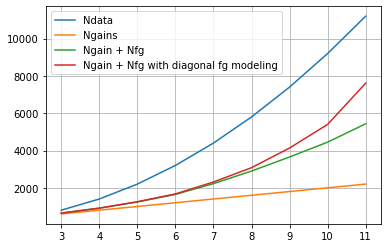

In [3]:
plt.plot(range(3, 12), ndata, label='Ndata')
plt.plot(range(3, 12), ngains, label='Ngains')
plt.plot(range(3, 12), np.asarray(nparams) + np.asarray(ngains), label='Ngain + Nfg')
plt.plot(range(3, 12), np.asarray(nparams_zd) + np.asarray(ngains), label='Ngain + Nfg with diagonal fg modeling')

plt.legend()
plt.grid()

In [27]:
# test fitting foregrounds
uvd_gsm, uvd_eor = visibilities.compute_visibilities(output_dir='./', nside_sky=256, antenna_count=11,
                                                       nf=200, df=200e3, f0=150e6, antenna_diameter=2.,
                                                       fractional_spacing=5, eor_fg_ratio=10**(-3), clobber=True)
uvd_total = copy.deepcopy(uvd_gsm)
uvd_total.data_array += uvd_eor.data_array

evals, evecs = covariances.cov_mat_simple_evecs(uvdata=uvd_total, antenna_diameter=2., eigenval_cutoff=1e-10, antenna_chromaticity=2. / 3e8)
# initialize with true foreground coefficients
# plus a perturbation.
data = copy.deepcopy(uvd_total.data_array.squeeze()).reshape(uvd_total.Nbls * uvd_total.Nfreqs) 
mdata = np.mean(data) * 0
data -= mdata
rmsdata = np.sqrt(np.mean(np.abs(data) ** 2.))
data /= rmsdata


invalid value encountered in sqrt


File exists; clobbering


invalid value encountered in sqrt


In [117]:

fg_coeffs_true = evecs.T @ data
fg_coeffs = fg_coeffs_true + .1 * fg_coeffs_true * (np.random.randn(len(fg_coeffs_true)))
np.std(uvd_eor.data_array)/np.std(uvd_gsm.data_array)

0.000999631558268793

In [120]:
weights = tf.convert_to_tensor(np.ones(data.shape, dtype=np.float64))

foreground_coefficients_real = tf.Variable(tf.convert_to_tensor(fg_coeffs.real))
foreground_coefficients_imag = tf.Variable(tf.convert_to_tensor(fg_coeffs.imag))

foreground_basis_vectors = tf.convert_to_tensor(evecs)

data_real = tf.convert_to_tensor(data.real)
data_imag = tf.convert_to_tensor(data.imag)

loss = lambda: .5 * tf.reduce_mean(tf.math.square(data_real - tf.math.reduce_sum(foreground_basis_vectors * foreground_coefficients_real, axis=1) * weights)) \
               + .5 * tf.reduce_mean(tf.math.square(data_imag - tf.math.reduce_sum(foreground_basis_vectors * foreground_coefficients_imag, axis=1) * weights))

opt = tf.optimizers.Adamax(lr=1e-2)

foreground_coefficients_real_last = foreground_coefficients_real.numpy()
foreground_coefficients_imag_last = foreground_coefficients_imag.numpy()
opt.minimize(loss, [foreground_coefficients_real, foreground_coefficients_imag])

delta_real = np.abs(foreground_coefficients_real.numpy() - foreground_coefficients_real_last).max()
delta_imag = np.abs(foreground_coefficients_imag.numpy() - foreground_coefficients_imag_last).max()




In [121]:
loss()

<tf.Tensor: shape=(), dtype=float64, numpy=0.009325034913852111>

In [123]:
var_history_real = []
var_history_imag = []
loss_history = []
tol = 1e-5
step = 0
maxsteps = 3500
while (delta_real >= tol or delta_imag >= tol) and step < maxsteps:
    opt.minimize(loss, [foreground_coefficients_real, foreground_coefficients_imag])
    delta_real = np.abs(foreground_coefficients_real.numpy() - foreground_coefficients_real_last).max()
    delta_imag = np.abs(foreground_coefficients_imag.numpy() - foreground_coefficients_imag_last).max()
    foreground_coefficients_real_last = foreground_coefficients_real.numpy()
    var_history_real.append(foreground_coefficients_real_last)
    foreground_coefficients_imag_last = foreground_coefficients_imag.numpy()
    var_history_imag.append(foreground_coefficients_imag_last)
    loss_history.append(loss().numpy())
    step += 1

In [124]:
loss()

<tf.Tensor: shape=(), dtype=float64, numpy=6.963732743887326e-10>

In [83]:
%%timeit
opt.minimize(loss, [foreground_coefficients_real, foreground_coefficients_imag])


156 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
step

432

In [32]:
delta_imag

6.191158696822185e-13

In [33]:
foreground_coefficients = foreground_coefficients_real.numpy() + 1j * foreground_coefficients_imag.numpy()
foreground_model = (foreground_basis_vectors.numpy() @ foreground_coefficients).reshape(uvd_eor.Nbls, uvd_eor.Nfreqs)
foreground_model = foreground_model * rmsdata + mdata

In [34]:
len(fg_coeffs_true)

3727

In [35]:
foreground_model_true = (foreground_basis_vectors.numpy() @ fg_coeffs_true).reshape(uvd_eor.Nbls, uvd_eor.Nfreqs)
foreground_model_true = foreground_model_true * rmsdata + mdata

In [36]:
len(fg_coeffs_true) + uvd_eor.Nants_data * uvd_eor.Nfreqs

5927

In [37]:
len(data)

11200

In [38]:
delta_imag

6.191158696822185e-13

IndexError: index 25 is out of bounds for axis 0 with size 25

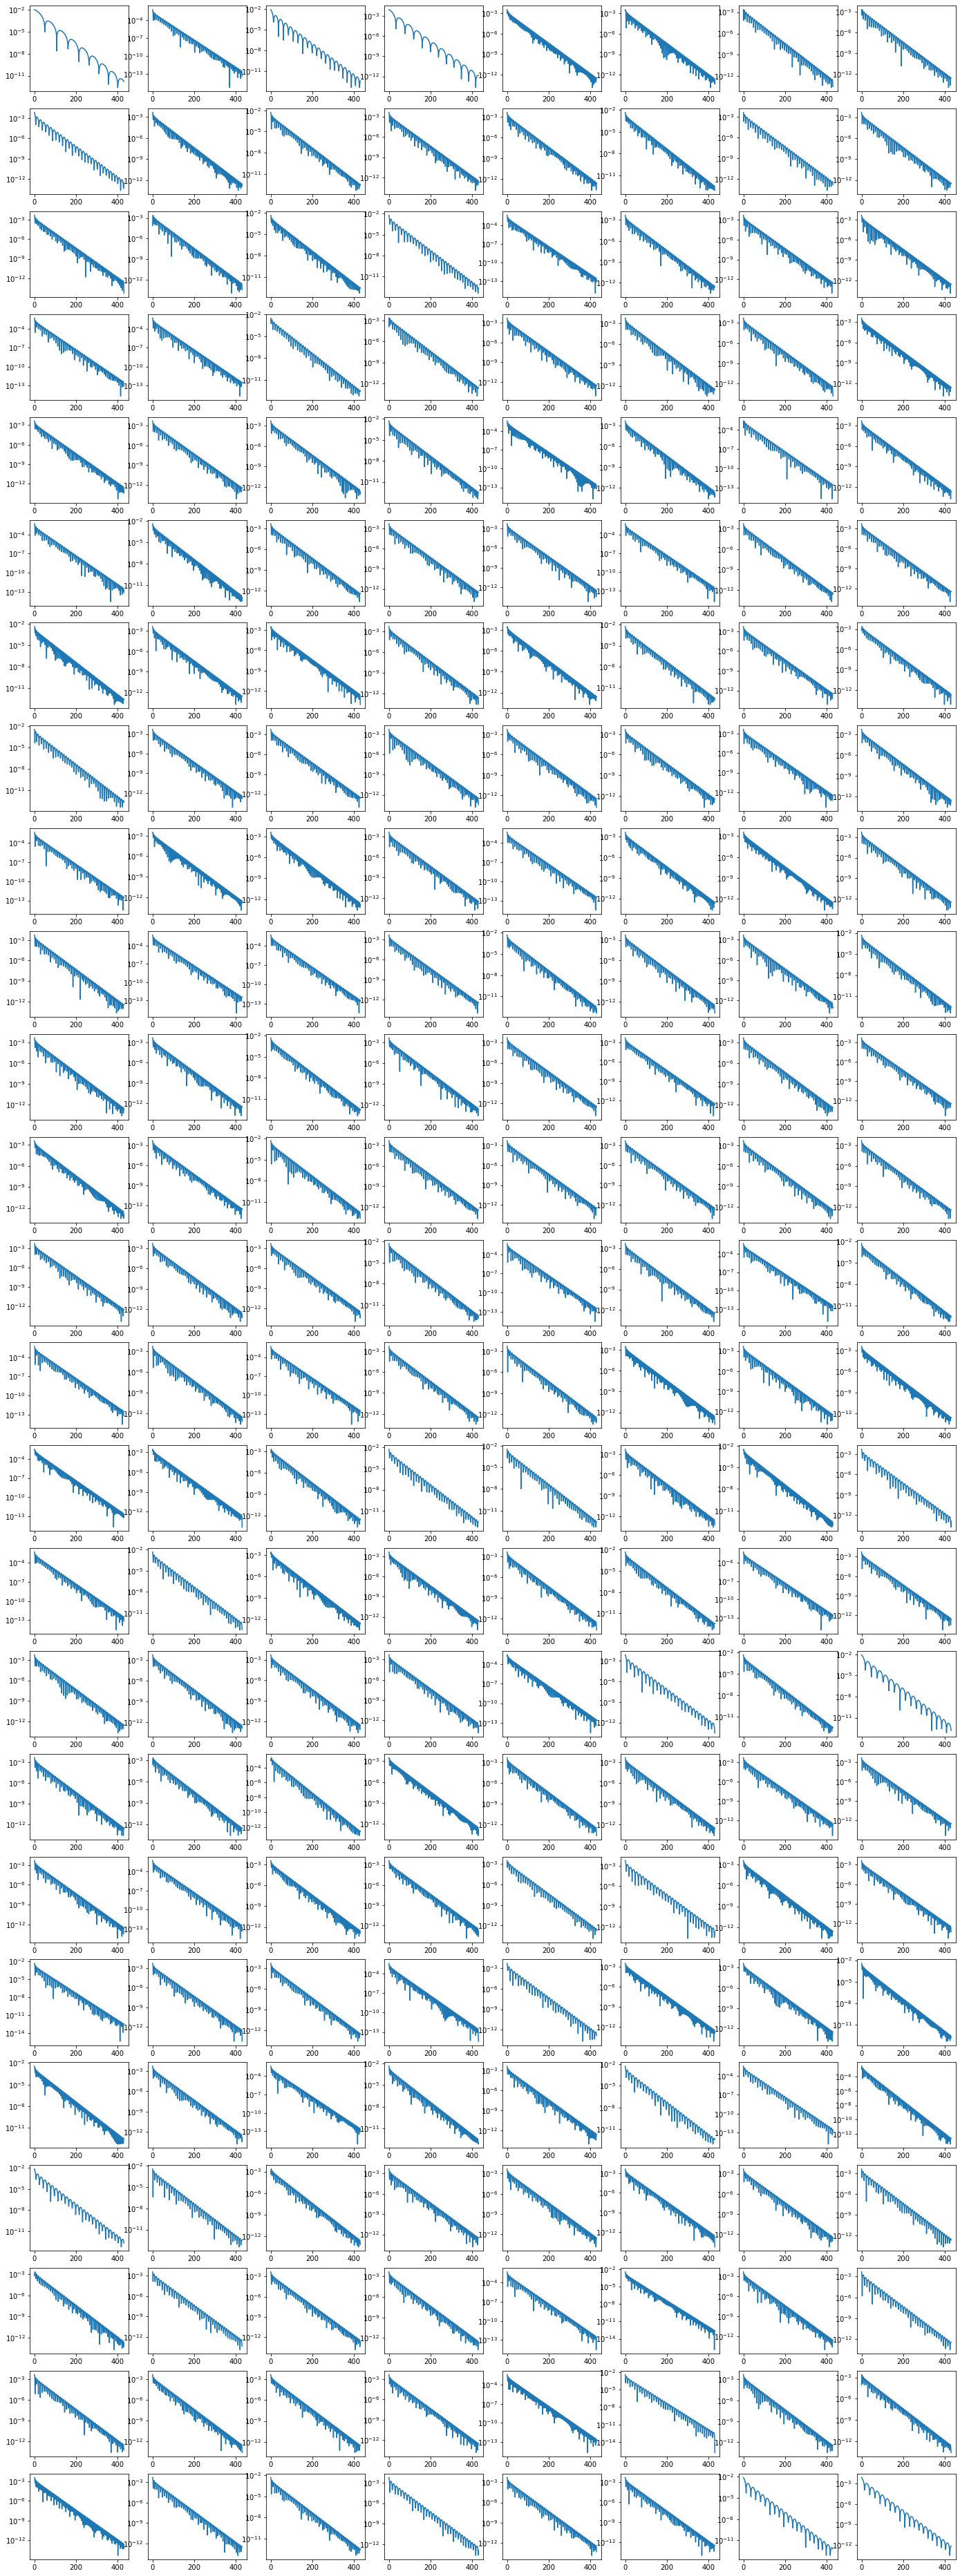

In [39]:
fig, axarr = plt.subplots(len(fg_coeffs[:200])//8, 8)
fig.set_size_inches(24, 68)
for i in range(len(var_history_real[0])):
    l = i % 8
    m = i // 8
    plt.sca(axarr[m][l])
    plt.plot(np.abs(np.diff(np.asarray(var_history_real).T[i])))
    plt.yscale('log')
plt.show()


In [40]:
delta_imag

6.191158696822185e-13

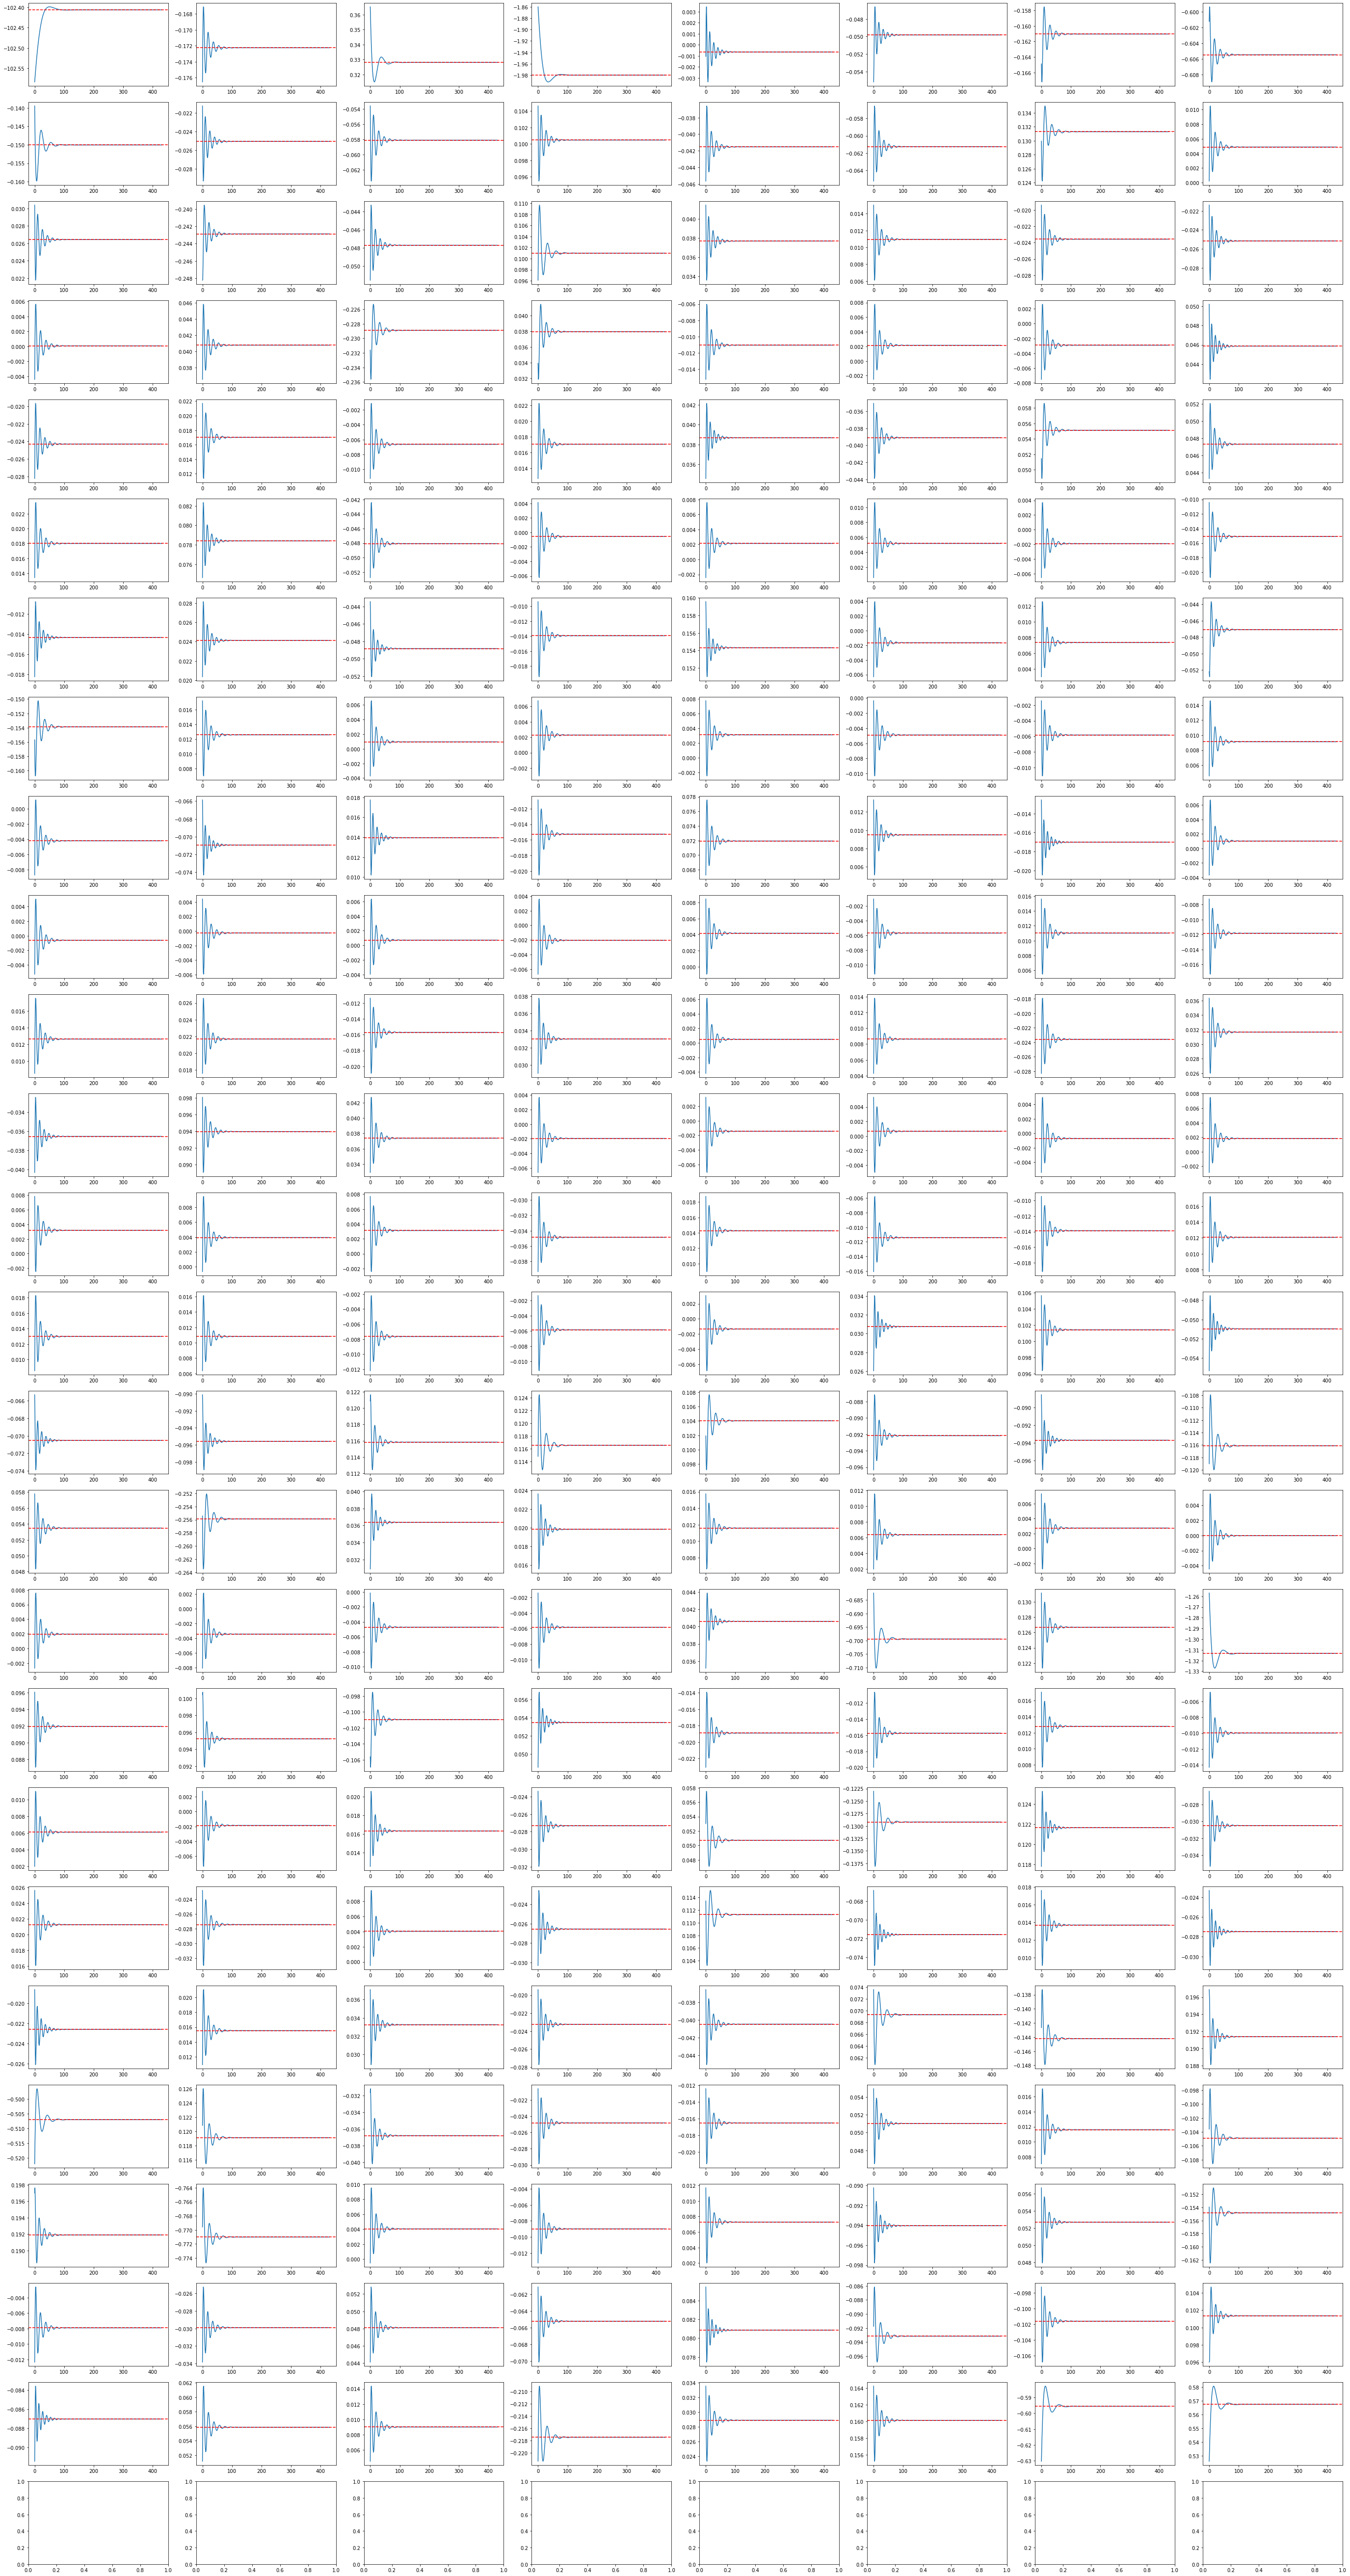

In [41]:
fig, axarr = plt.subplots(len(fg_coeffs[:200])//8 + 1, 8)
fig.set_size_inches(48, 96)
for i in range(200):
    l = i % 8
    m = i // 8
    plt.sca(axarr[m][l])
    plt.plot(np.asarray(var_history_real).T[i])
    plt.axhline(fg_coeffs_true[i].real, ls='--', color='r')
plt.show()


In [42]:
uvd_model = copy.deepcopy(uvd_total)
uvd_model.data_array = foreground_model.reshape(uvd_model.Nbls, 1, uvd_model.Nfreqs, 1)
uvd_resid = copy.deepcopy(uvd_total)
uvd_resid.data_array = uvd_total.data_array - uvd_model.data_array

In [43]:
uvd_resid_true = copy.deepcopy(uvd_total)
uvd_resid_true.data_array = uvd_total.data_array -  foreground_model_true.reshape(uvd_model.Nbls, 1, uvd_model.Nfreqs, 1)

In [44]:
uvd_noise = copy.deepcopy(uvd_total)
uvd_noise.data_array = uvd_total.data_array - uvd_gsm.data_array

In [45]:
np.mean(np.abs(uvd_total.data_array) ** 2.) ** .5 / np.mean(np.abs(uvd_eor.data_array) ** 2.) ** .5

1000.9973769687571

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or p

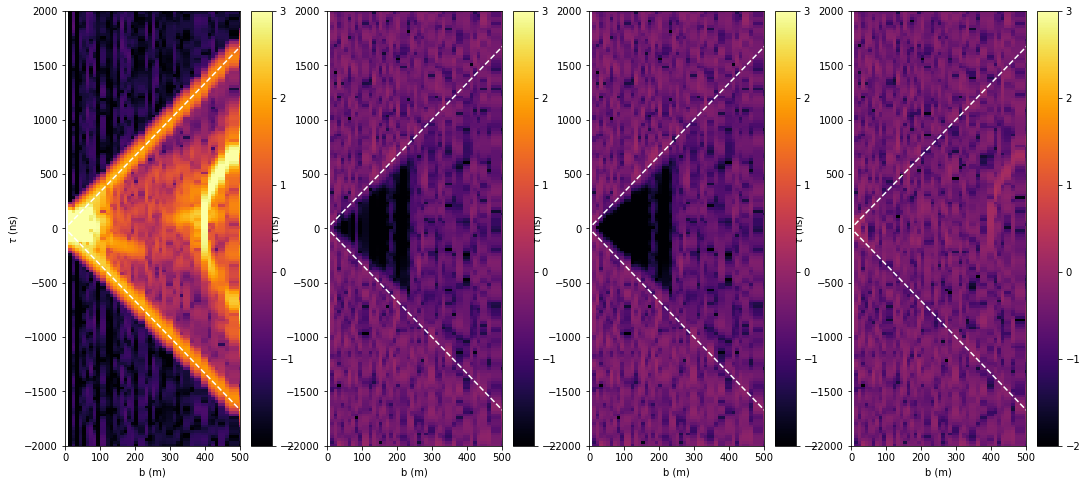

In [46]:
fig, axarr = plt.subplots(1, 4)
for i, uvt in enumerate([uvd_gsm, uvd_resid, uvd_resid_true, uvd_noise]):
    plt.sca(axarr[i])
    x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='cs11')
    xg, yg = np.meshgrid(x, y)
    plt.pcolor(xg, yg, np.log10(np.abs(ctot.T)), #extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-2, vmax=3, cmap='inferno')#, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    plt.xlim(0, 500)
    plt.ylim(-2000, 2000)
    plt.xlim()
fig.set_size_inches(18, 8)

# Try formatting data to make autodiff faster.

In [93]:
np.std(uvd_eor.data_array.real) / np.std(uvd_total.data_array.real)

2.2800186132798244e-06

In [94]:
# test fitting foregrounds
uvd_gsm, uvd_eor = visibilities.compute_visibilities(output_dir='./', nside_sky=128, antenna_count=6, include_autos=False,
                                                       nf=200, df=200e3, f0=150e6, antenna_diameter=2., compress_by_redundancy=False,
                                                       fractional_spacing=5, eor_fg_ratio=10**(-3), clobber=True)
uvd_total = copy.deepcopy(uvd_gsm)
uvd_total.data_array += uvd_eor.data_array
evals, evecs = covariances.cov_mat_simple_evecs(uvdata=uvd_total, antenna_diameter=2., eigenval_cutoff=1e-10, antenna_chromaticity=2. / 3e8, compress_by_redundancy=False)


invalid value encountered in sqrt


File exists; clobbering


invalid value encountered in sqrt


KeyboardInterrupt: 

In [60]:


# initialize with true foreground coefficients
# plus a perturbation.
data = copy.deepcopy(uvd_total.data_array.squeeze()).reshape(uvd_total.Nbls * uvd_total.Nfreqs) 
mdata = np.mean(data) * 0
data -= mdata
rmsdata = np.sqrt(np.mean(np.abs(data) ** 2.))
data /= rmsdata


In [61]:
fg_coeffs_true = evecs.T @ data
fg_coeffs = fg_coeffs_true
fg_coeffs = fg_coeffs_true + .1 * fg_coeffs_true * (np.random.randn(len(fg_coeffs_true)))
weights = tf.convert_to_tensor(np.ones(data.shape, dtype=np.float64))
gains_real = np.ones((uvd_total.Nants_data, uvd_total.Nfreqs))
gains_imag = np.zeros((uvd_total.Nants_data, uvd_total.Nfreqs))
gains_real += .2 * np.random.randn(*gains_real.shape)
gains_imag += .2 * np.random.randn(*gains_imag.shape)

In [62]:
# generate fitting tensors

# insert eigenvectors
fg_basis = np.zeros((uvd_total.Nants_data, uvd_total.Nants_data, uvd_total.Nfreqs, len(fg_coeffs_true)))
evecs_reshaped = [evecs[:, i].reshape(uvd_total.Nbls, uvd_total.Nfreqs).astype(np.float32) for i in range(evecs.shape[-1])]
for fg_ind in range(len(fg_coeffs_true)):
    for vind, (i, j) in enumerate(zip(uvd_total.ant_1_array, uvd_total.ant_2_array)):
        fg_basis[i, j, :, fg_ind] = evecs_reshaped[fg_ind][vind]

dfit_r = np.zeros((uvd_total.Nants_data, uvd_total.Nants_data, uvd_total.Nfreqs))
dfit_i = np.zeros((uvd_total.Nants_data, uvd_total.Nants_data, uvd_total.Nfreqs))
# insert data
for vind, (i, j) in enumerate(zip(uvd_total.ant_1_array, uvd_total.ant_2_array)):
    dfit_r[i, j] = uvd_total.data_array[vind, :].real.squeeze()
    dfit_i[i, j] = uvd_total.data_array[vind, :].imag.squeeze()

dfit_r -= mdata.real
dfit_r /= rmsdata
dfit_i -= mdata.imag
dfit_i /= rmsdata


In [69]:
dtype_opt = np.float32
dfit_r = tf.convert_to_tensor(dfit_r, dtype=dtype_opt)
dfit_i = tf.convert_to_tensor(dfit_i, dtype=dtype_opt)
fg_basis = tf.convert_to_tensor(fg_basis, dtype=dtype_opt)
gr = tf.Variable(tf.convert_to_tensor(gains_real, dtype=dtype_opt))
gi = tf.Variable(tf.convert_to_tensor(gains_imag, dtype=dtype_opt))
fg_r = tf.Variable(tf.convert_to_tensor(fg_coeffs.real, dtype=dtype_opt))
fg_i = tf.Variable(tf.convert_to_tensor(fg_coeffs.imag, dtype=dtype_opt))

In [70]:
correction_factor = uvd_total.Nants_data ** 2. / uvd_total.Nbls

In [71]:
correction_factor

2.2

In [72]:
def cal_loss_matrix():
    grgr = tf.einsum('ik,jk->ijk',gr, gr)
    gigi = tf.einsum('ik,jk->ijk',gi, gi)
    grgi = tf.einsum('ik,jk->ijk',gr, gi)
    gigr = tf.einsum('ik,jk->ijk',gi, gr)
    vr = tf.reduce_sum(fg_basis * fg_r, axis=3)
    vi = tf.reduce_sum(fg_basis * fg_i, axis=3)
    model_r = (grgr + gigi) * vr + (grgi - gigr) * vi
    model_i = (gigr - grgi) * vr + (grgr + gigi) * vi
    return tf.reduce_mean(tf.square(dfit_r - model_r) + tf.square(dfit_i - model_i))

In [411]:
%%timeit
opt.minimize(cal_loss_matrix, var_list=[gr, gi, fg_r, fg_i])

178 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
var_history_real = [fg_r.numpy()]
var_history_gr = [gr.numpy()]
var_history_imag = [fg_i.numpy()]
var_history_gi = [gi.numpy()]
opt = tf.optimizers.Adamax(lr=1e-2)

loss_history = [cal_loss_matrix().numpy()]
opt.minimize(cal_loss_matrix, [fg_r, fg_i, gr, gi])
delta_loss = np.abs(cal_loss_matrix().numpy() - loss_history[-1])


In [74]:
maxsteps = 10000
tol = 1e-14 / correction_factor
step = 0

import tqdm
for step in tqdm.tqdm(range(maxsteps)):
    opt.minimize(cal_loss_matrix, [fg_r, fg_i, gr, gi])
    var_history_real.append(fg_r.numpy())
    var_history_imag.append(fg_i.numpy())
    var_history_gr.append(gr.numpy())
    var_history_gi.append(gi.numpy)
    delta_loss = cal_loss_matrix().numpy() - loss_history[-1]
    loss_history.append(loss_history[-1] + delta_loss)
    delta_loss = np.abs(delta_loss)
    if delta_loss <= tol:
        break

100%|██████████| 10000/10000 [1:37:34<00:00,  1.71it/s]


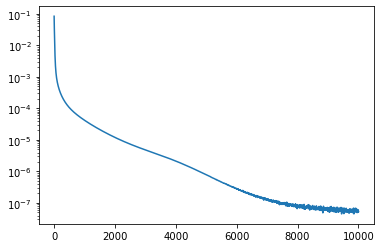

In [75]:
plt.plot(loss_history)
plt.yscale('log')

In [76]:
def yield_model_spectrum(a1, a2, grt=gr, git=gi, fg_rt=fg_r, fg_it=fg_i):
    grgr = tf.einsum('ik,jk->ijk',grt, grt)
    gigi = tf.einsum('ik,jk->ijk',git, git)
    grgi = tf.einsum('ik,jk->ijk',grt, git)
    gigr = tf.einsum('ik,jk->ijk',git, grt)
    vr = tf.reduce_sum(fg_basis * fg_rt, axis=3)
    vi = tf.reduce_sum(fg_basis * fg_it, axis=3)
    model_r = (grgr + gigi) * vr + (grgi - gigr) * vi
    model_i = (gigr - grgi) * vr + (grgr + gigi) * vi
    return model_r[a1, a2].numpy() + 1j * model_i[a1, a2].numpy()

def yield_data_spectrum(a1, a2):
    return dfit_r[a1, a2].numpy() + 1j * dfit_i[a1, a2].numpy()


def yield_model(grt=gr, git=gi, fg_rt=fg_r, fg_it=fg_i):
    uvd_model = copy.deepcopy(uvd_total)
    for vind, (i, j) in enumerate(zip(uvd_total.ant_1_array, uvd_total.ant_2_array)):
        uvd_model.data_array[vind,0, :, 0] = yield_model_spectrum(i, j, grt=gr, git=gi, fg_rt=fg_r, fg_it=fg_i)
    uvd_model.data_array *= rmsdata
    return uvd_model

Casting complex values to real discards the imaginary part


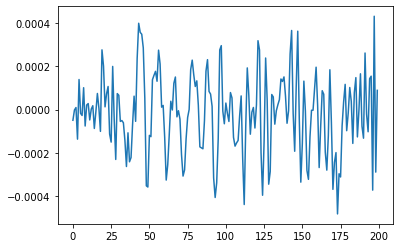

In [77]:
plt.plot(yield_model_spectrum(10, 4) - yield_data_spectrum(10, 4))
#plt.plot(yield_data_spectrum(4, 4))

In [78]:
uvd_calibrated_model = yield_model()
uvd_cal_resid = copy.deepcopy(uvd_total)
uvd_cal_resid.data_array -= uvd_calibrated_model.data_array

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


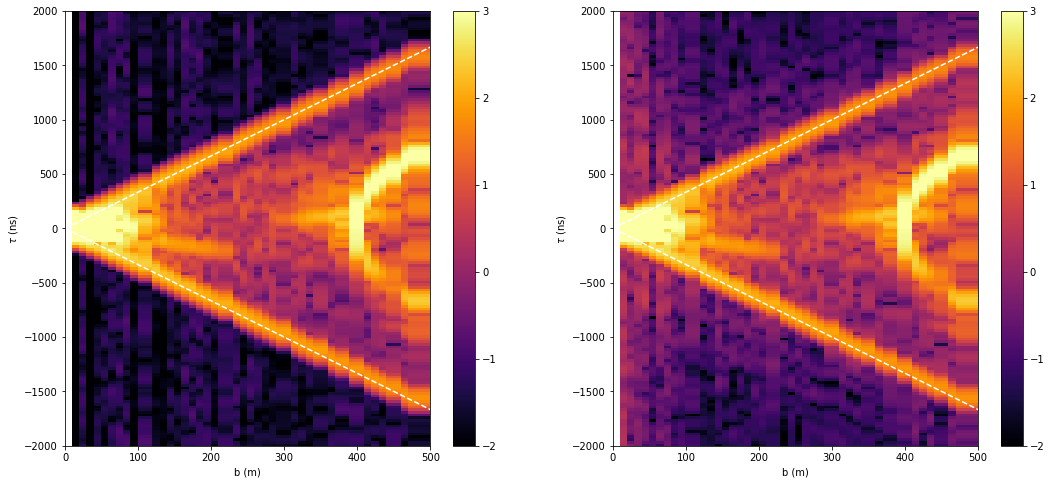

In [79]:
fig, axarr = plt.subplots(1, 2)
for i, uvt in enumerate([uvd_total, uvd_calibrated_model]):
    plt.sca(axarr[i])
    x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='cs11')
    xg, yg = np.meshgrid(x, y)
    plt.pcolor(xg, yg, np.log10(np.abs(ctot.T)), #extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-2, vmax=3, cmap='inferno')#, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    plt.xlim(0, 500)
    plt.ylim(-2000, 2000)
    plt.xlim()
fig.set_size_inches(18, 8)

In [82]:
uvd_noise = copy.deepcopy(uvd_total)
uvd_noise.data_array = uvd_total.data_array - uvd_gsm.data_array

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


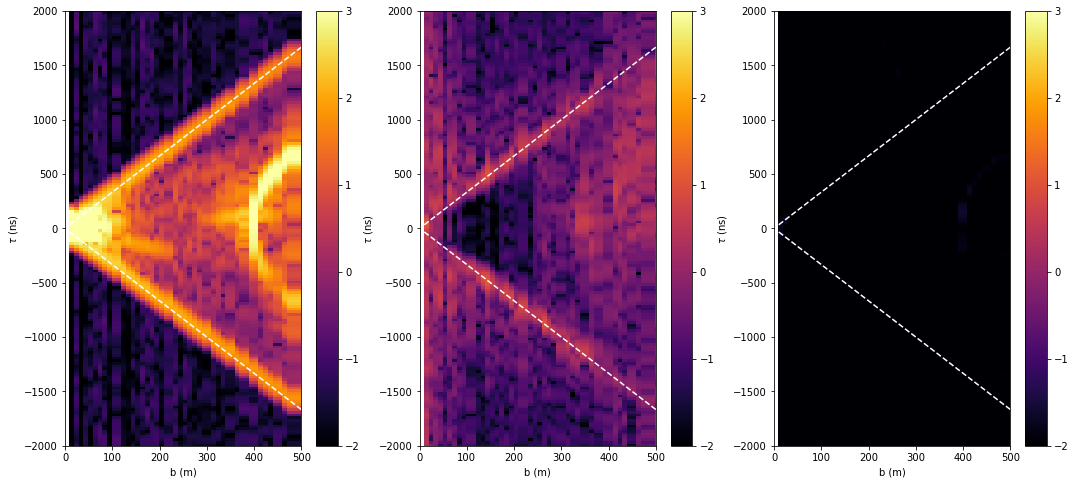

In [89]:
fig, axarr = plt.subplots(1, 3)
for i, uvt in enumerate([uvd_total,  uvd_cal_resid, uvd_eor]):
    plt.sca(axarr[i])
    x, y, ctot = visualization.delay_transform_sort_by_baseline_length(uvt, window='cs11')
    xg, yg = np.meshgrid(x, y)
    plt.pcolor(xg, yg, np.log10(np.abs(ctot.T)), #extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=-2, vmax=3, cmap='inferno')#, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    plt.xlim(0, 500)
    plt.ylim(-2000, 2000)
    plt.xlim()
fig.set_size_inches(18, 8)